# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
import time

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.0


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
        self.image_dirs = image_dirs
        self.transform = transform
        
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [5]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [6]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [7]:
batch_size = 6
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 470
Num of test batches 15


# Data Visualization

In [8]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize = (8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green' if preds[i] == labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

# Creating the Model

In [9]:
resnet18 = torchvision.models.resnet18(pretrained = True)


In [10]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [11]:
def show_preds(show_acc=False):
    acc = 0.
    resnet18.eval()

    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

    if show_acc:
        for batch_num, (images, labels) in enumerate(dl_test):
            images, labels = next(iter(dl_test))
            outputs = resnet18(images)
            _, preds = torch.max(outputs, 1)
            acc += sum((preds == labels).numpy())

        print(len(test_dataset))
        acc /= len(test_dataset)
        print(f'Test accuracy: {acc:.4f}')

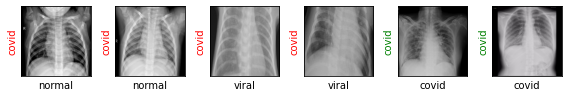

90
Test accuracy: 0.2889


In [12]:
show_preds(True)

# Training the Model

In [13]:
def train(epochs):
    start_time = time.time()
    print('starting training..')
    for e in range(epochs):
        print('='*20)
        print(f'starting epoch {e + 1}/{epochs}')
        print('=' * 20)
        train_loss = 0
        resnet18.train()
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('evaluating at step', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc /= len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                resnet18.train()
                
                # if acc > 0.95:
                #     print('performance condition satisfied')
                #     return
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
    print('---%s seconds ---' % (time.time() - start_time))
        

starting training..
starting epoch 1/1
evaluating at step 0
Val loss: 1.1464, Acc: 0.4000


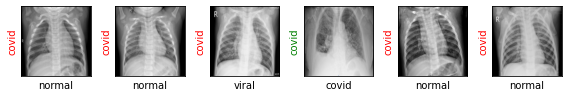

evaluating at step 20
Val loss: 0.6732, Acc: 0.7444


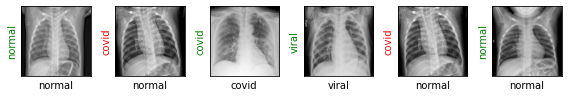

evaluating at step 40
Val loss: 0.4708, Acc: 0.8556


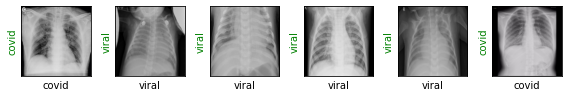

evaluating at step 60
Val loss: 0.2242, Acc: 0.9667


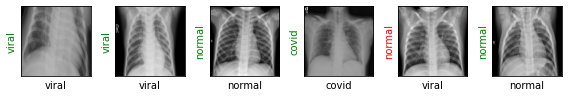

evaluating at step 80
Val loss: 0.2394, Acc: 0.9111


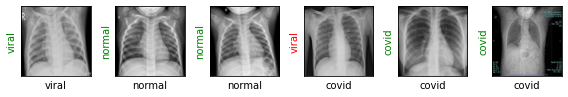

evaluating at step 100
Val loss: 0.2784, Acc: 0.9111


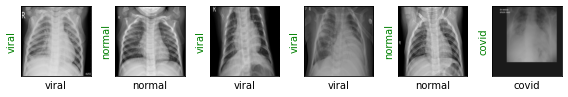

evaluating at step 120
Val loss: 0.1972, Acc: 0.9556


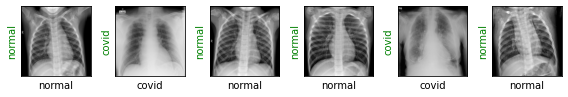

evaluating at step 140
Val loss: 0.2952, Acc: 0.9333


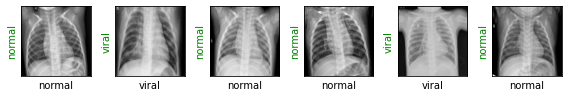

evaluating at step 160
Val loss: 0.2054, Acc: 0.9333


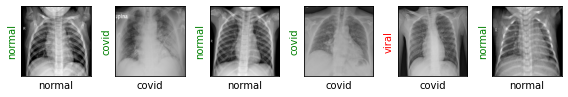

evaluating at step 180
Val loss: 0.2146, Acc: 0.9333


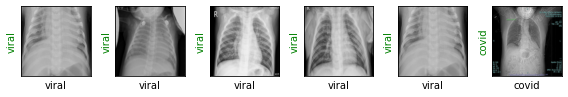

evaluating at step 200
Val loss: 0.2541, Acc: 0.9000


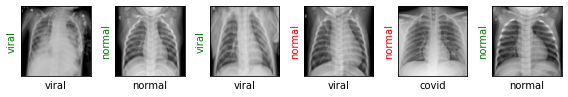

evaluating at step 220
Val loss: 0.1979, Acc: 0.9222


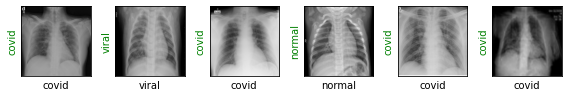

evaluating at step 240
Val loss: 0.1527, Acc: 0.9778


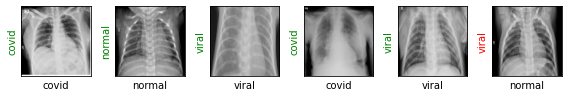

evaluating at step 260
Val loss: 0.1652, Acc: 0.9333


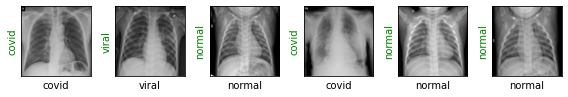

evaluating at step 280
Val loss: 0.2308, Acc: 0.9444


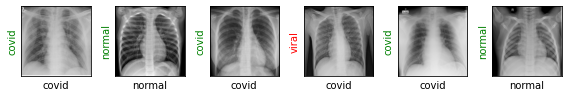

evaluating at step 300
Val loss: 0.1529, Acc: 0.9778


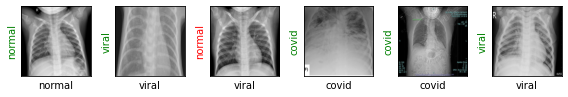

evaluating at step 320
Val loss: 0.1152, Acc: 0.9667


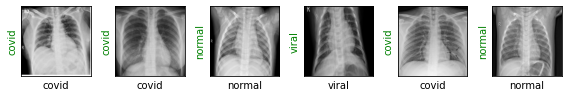

evaluating at step 340
Val loss: 0.1191, Acc: 0.9667


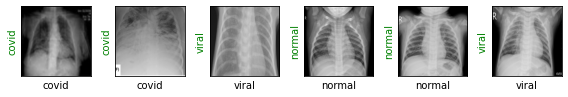

evaluating at step 360
Val loss: 0.1704, Acc: 0.9444


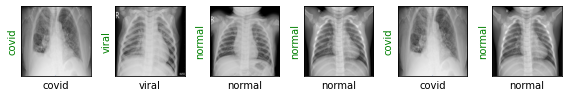

evaluating at step 380
Val loss: 0.1583, Acc: 0.9667


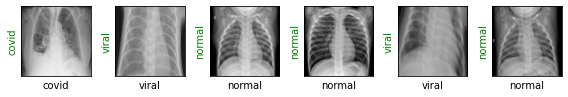

evaluating at step 400
Val loss: 0.1311, Acc: 0.9556


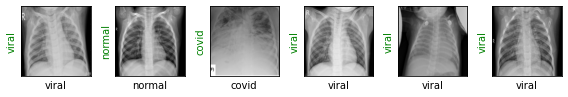

evaluating at step 420
Val loss: 0.0667, Acc: 0.9889


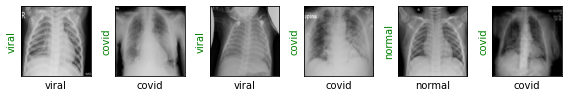

evaluating at step 440
Val loss: 0.1120, Acc: 0.9667


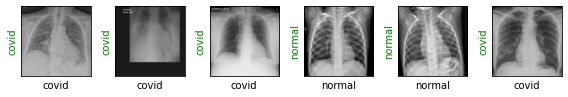

In [ ]:
train(epochs = 1)

In [ ]:
show_preds(True)